In [2]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange

In [3]:
#path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#/Ti scope/2023_11_28/2023_11_28_10x_1.0x_pAAA_Ti_Pos6.ome.tif

In [31]:
scope_name = 'Tweez scope'
#scope_name = 'Ti scope'
path_scope = os.path.join(path_ext, scope_name)
exp_date = '2023_12_08'
path = os.path.join(path_scope, exp_date)
folder_masks = 'contour_masks'
folder_results = 'results'
folder_fluo = 'fluo'
folder_graphs = 'graphs'
folder_velocity = 'velocity_data'
vectors = ['pAAA', 'pLPT20&41', 'pLPT107&41', 'pLPT119&41']
channels = {'pAAA': {'rfp':0,'yfp':1,'cfp':2,'phase':3},
            'pLPT20&41': {'yfp':0,'cfp':1,'phase':2}, 
            'pLPT119&41': {'yfp':0,'cfp':1,'phase':2},
            'pLPT107&41': {'rfp':0,'yfp':1,'cfp':2,'phase':3}}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
vector = 'pLPT20&pLPT41'
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [32]:
exp_sum = pd.read_excel('../Notebooks/Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
i = exp_sum[(exp_sum.formatted_dates == exp_date) & (exp_sum.Machine == scope_name)].index[0]

0

In [34]:
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-12-08,Tweez scope,MC4100,pLPT20&pLPT41,aTc,10^(-5),2023_12_08


In [36]:
positions = pd.read_excel('../Notebooks/Positions.xlsx')
poss = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')].Position.unique()
poss

array([ 0,  1,  2,  4,  6,  7, 11, 12, 13, 17, 18, 19, 21, 23, 24, 29, 30,
       31, 32, 34, 35, 36, 37, 38])

In [37]:
df_pos = positions[(positions.Date == exp_sum.loc[i, 'Date']) & 
        (positions.DNA == vector) & 
        (positions.Machine == scope_name) & 
        (positions.Quality == 'Very good')]
df_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,Quality,exp length,Colonies,Centers,Radius,radj
240,2023-12-08,Tweez scope,0,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"515, 510",70.0,30.0
241,2023-12-08,Tweez scope,1,MC4100,pLPT20&pLPT41,ATC-,1,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"515, 510",100.0,20.0
242,2023-12-08,Tweez scope,2,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"510, 505",70.0,50.0
244,2023-12-08,Tweez scope,4,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,1.0,"510, 510",100.0,50.0
246,2023-12-08,Tweez scope,6,MC4100,pLPT20&pLPT41,ATC-,2,10^(-5),14:18:00,19:07:00,Very good,406,2.0,"340, 715",70.0,30.0


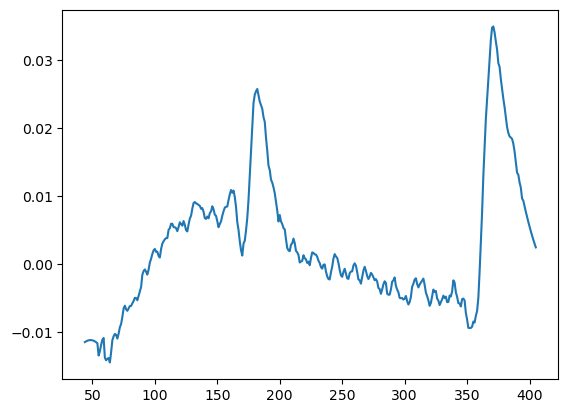

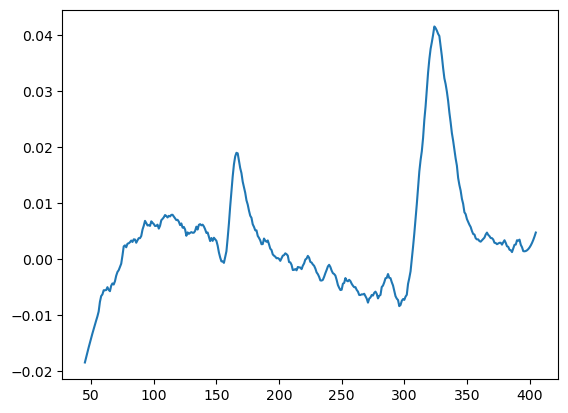

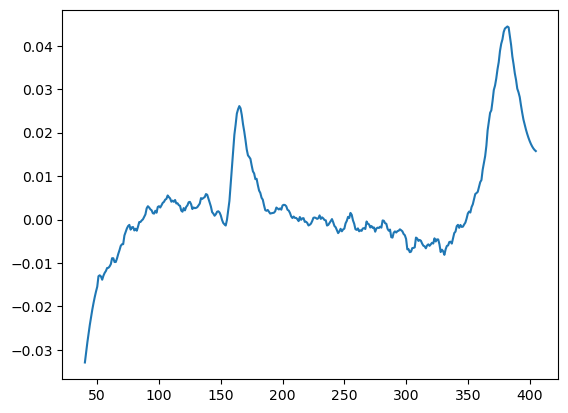

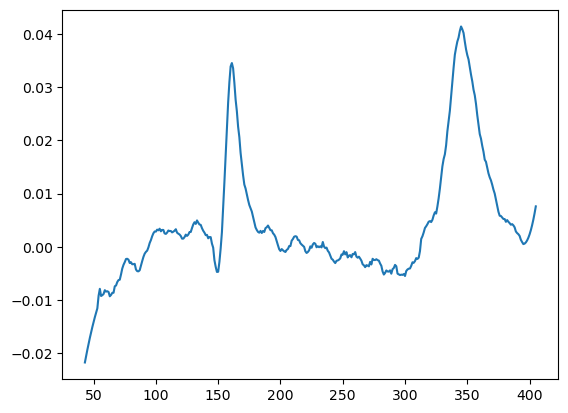

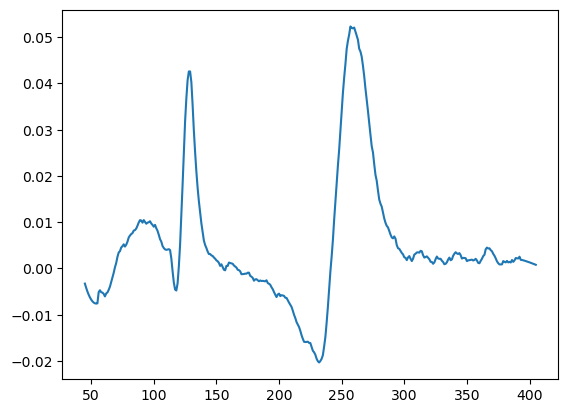

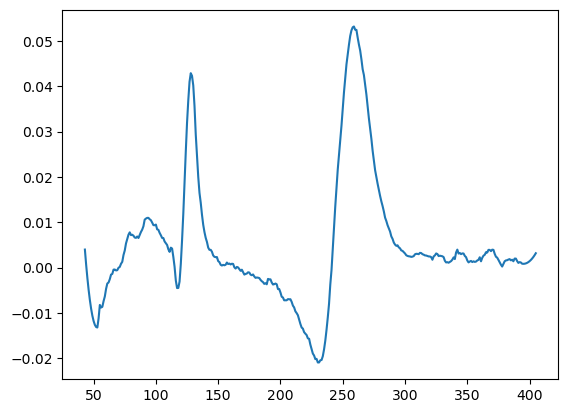

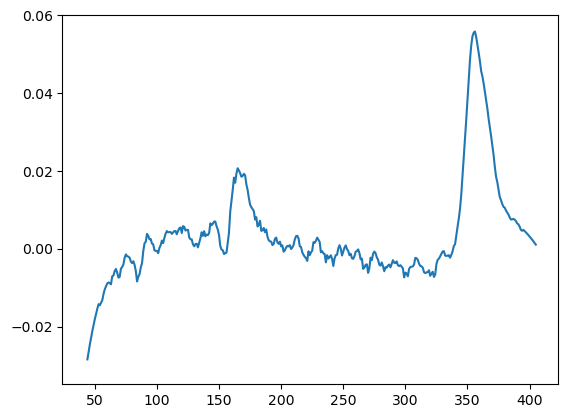

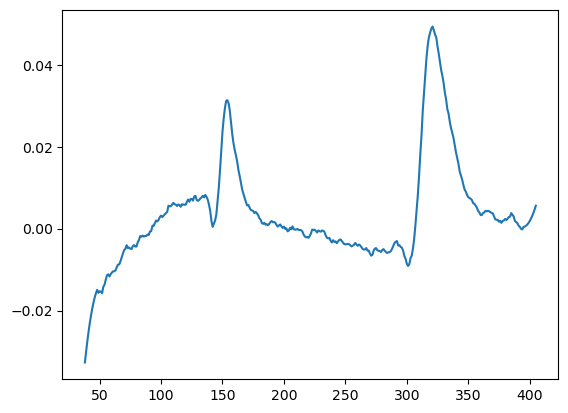

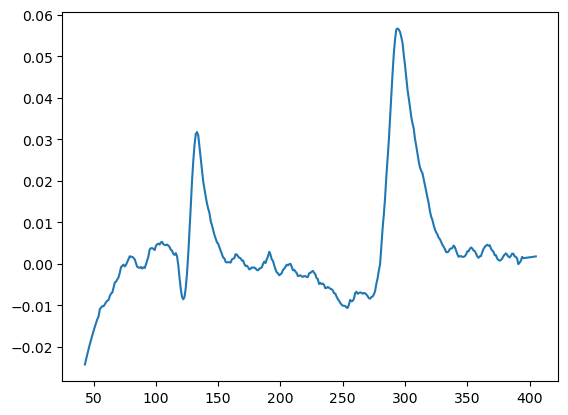

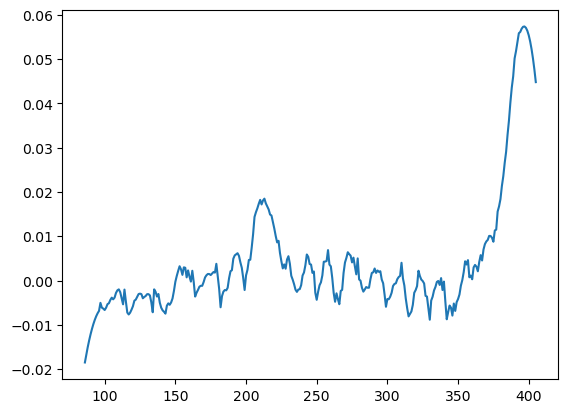

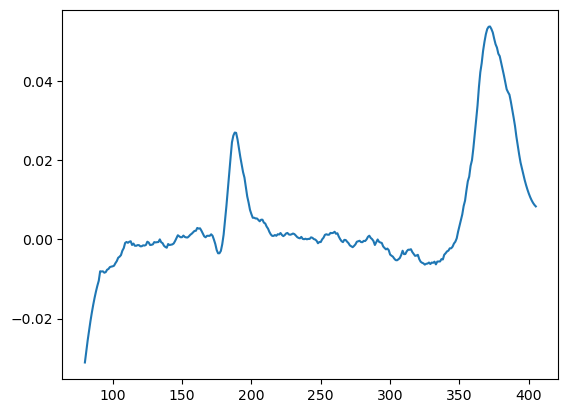

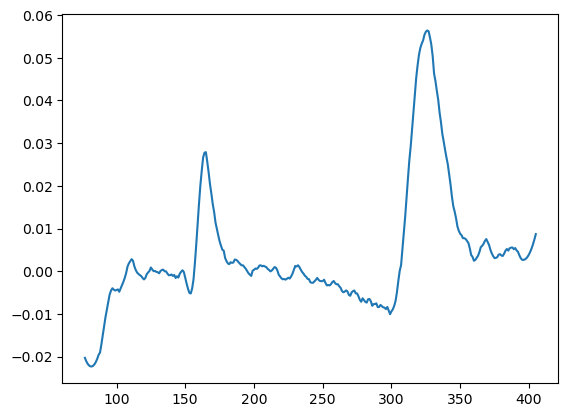

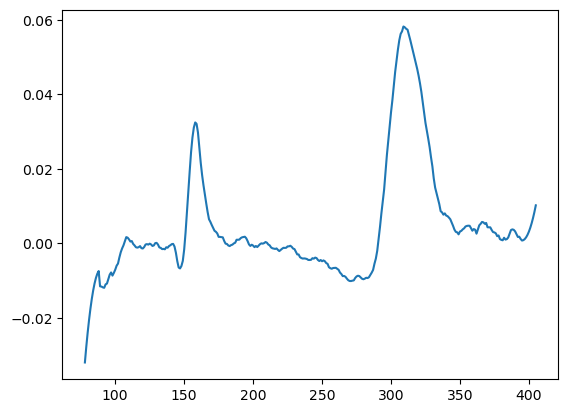

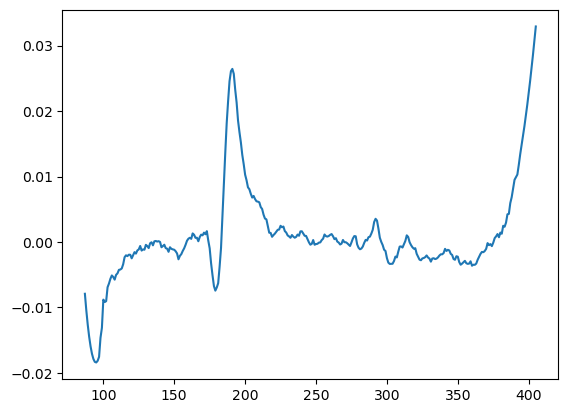

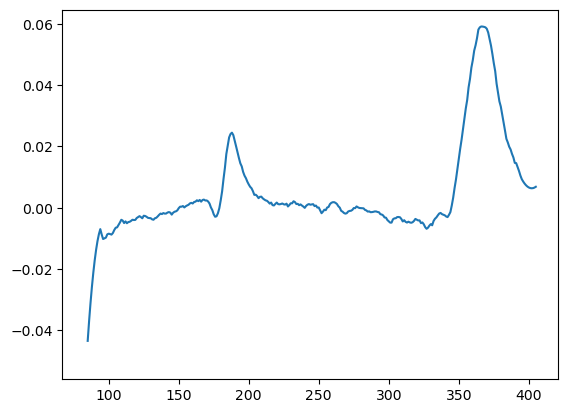

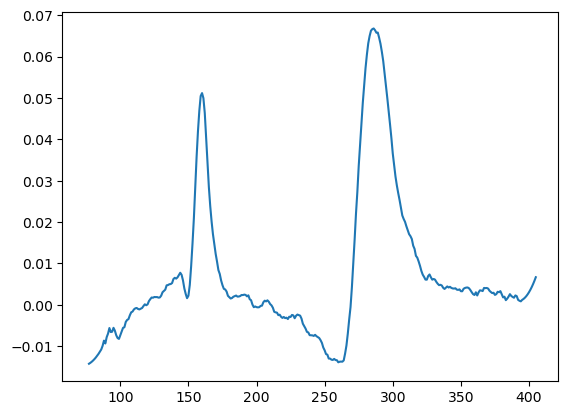

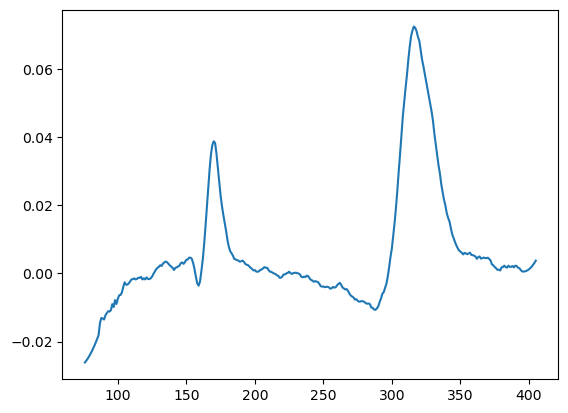

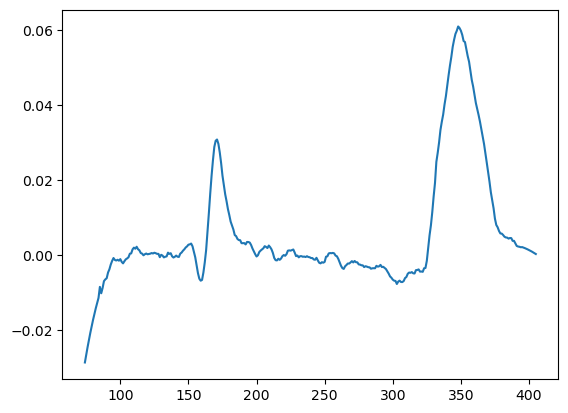

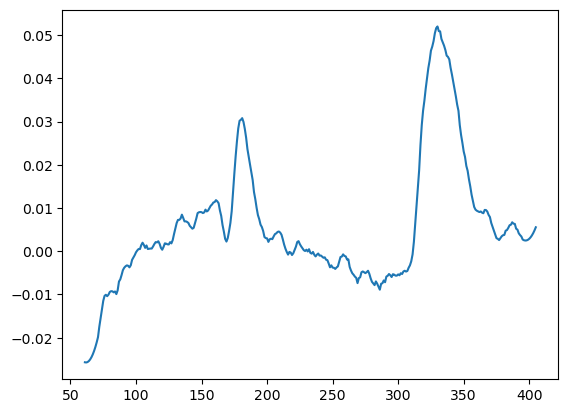

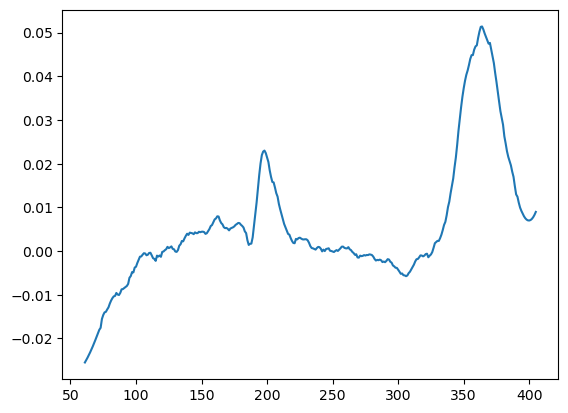

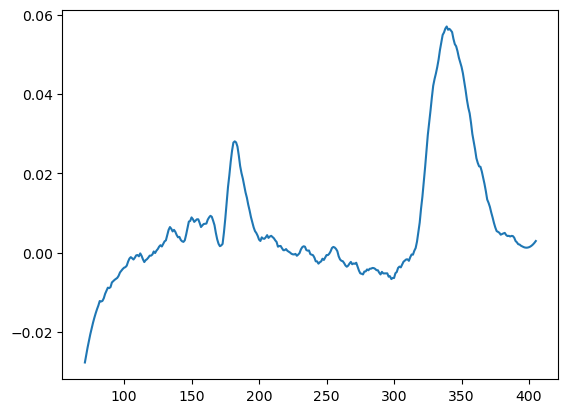

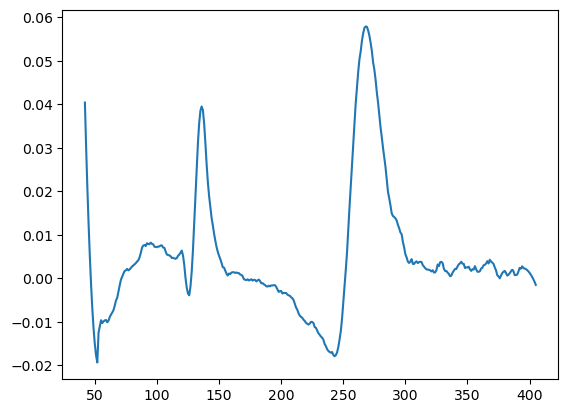

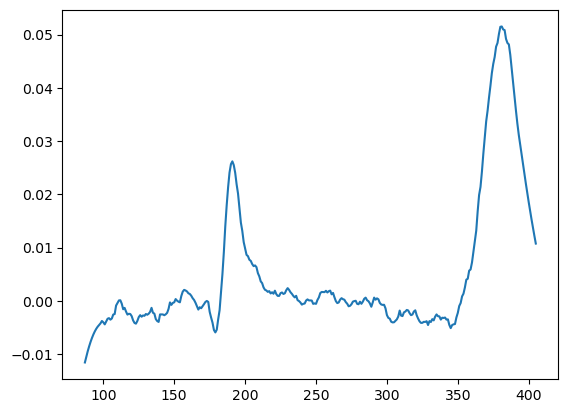

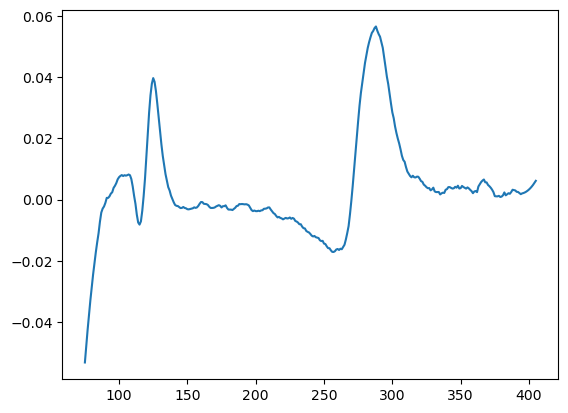

In [46]:
dlrhos_center = np.zeros((len(poss), 406, 2))
for i, pos in enumerate(poss):
    dlrhos_center[i,:,:] = np.load(os.path.join(path_ext,scope_name,exp_date,folder_results,f"pos{pos}", 'dlrho_center.npy'))
    plt.plot(dlrhos_center[i,:,0])
    plt.show()

In [53]:
npos = poss.shape[0]
npos

20

In [57]:
nt,nc = 398, 3
mean = np.zeros((npos,nt,nc))
rho = np.zeros((npos,nt,nc-1))
lrho = np.zeros((npos,nt,nc-1))
dlrho = np.zeros_like(lrho) + np.nan

In [ ]:
for pos in poss:
    print(f"Pos {pos}")
    fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
    print(fname)
    path_im = os.path.join(path, fname)
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    im_all = imread(path_im)
    im_all = im_all[:,:,:,:ph_chn]
    nt,nx,ny,nc = im_all.shape    
    path_results = os.path.join(path, folder_results, f"pos{pos}")
    edt = np.load(os.path.join(path_results,'edt.npy'))
    edt = edt[:,:,:]

    bg = np.zeros((nc,))
    for c in range(nc):
        bg[c] = im_all[0,:100,:100,c].mean()
    
    rw = 16
    Rmax = edt.max()    
    for t in range(nt):    
        tedt = edt[t,:,:]
        idx = tedt > Rmax - rw        
        if np.sum(idx)>0:
            if fluo_chns == 3:
                ntim0 = im_all[t,:,:,rfp_chn].astype(float) - bg[rfp_chn]
                ntim1 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim2 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]
                x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
                mean[pos,t,rfp_chn] = x.mean()
                mean[pos,t,yfp_chn] = y.mean()
                mean[pos,t,cfp_chn] = z.mean()            
            elif fluo_chns == 2:                
                ntim0 = im_all[t,:,:,yfp_chn].astype(float) - bg[yfp_chn]
                ntim1 = im_all[t,:,:,cfp_chn].astype(float) - bg[cfp_chn]               
                x,y = ntim0[idx], ntim1[idx]
                mean[pos,t,yfp_chn] = x.mean()
                mean[pos,t,cfp_chn] = y.mean()
    
    rho[pos,:,0] = mean[pos,:,0] / mean[pos,:,2]
    rho[pos,:,1] = mean[pos,:,1] / mean[pos,:,2]
    lrho[pos,:,:] = np.log(rho[pos,:,:])
    dlrho[pos,:,:] = savgol_filter(lrho[pos,:,:], 21, 3, deriv=1, axis=0)

Pos 0
2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos0.ome.tif


/tmp/ipykernel_360475/848722237.py:40: RuntimeWarning: invalid value encountered in divide
  rho[pos,:,0] = mean[pos,:,0] / mean[pos,:,2]
/tmp/ipykernel_360475/848722237.py:41: RuntimeWarning: invalid value encountered in divide
  rho[pos,:,1] = mean[pos,:,1] / mean[pos,:,2]


Pos 1
2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos1.ome.tif


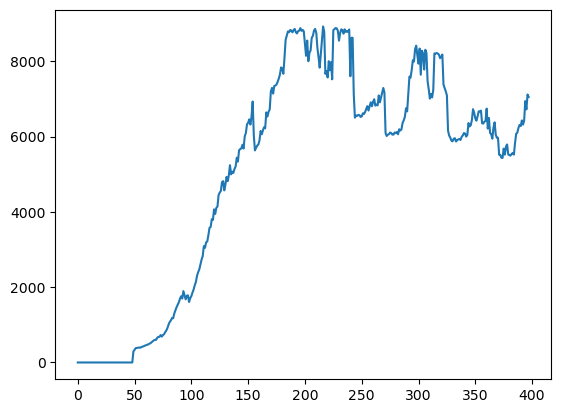

In [20]:
plt.plot(mean[:,0])
plt.show()

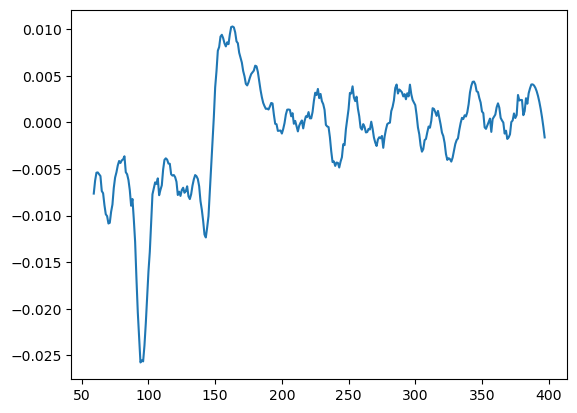

In [29]:
plt.plot(dlrho[:,1])
plt.show()

In [ ]:
    if fluo_chns == 3:
        kymo_rho = np.stack([kymo[:,:,0] / kymo[:,:,2], kymo[:,:,1] / kymo[:,:,2]], axis=2)
        cs = 2
    else:
        kymo_rho = kymo[:,:,0] / kymo[:,:,1]
        cs = 1

    lkymo_rho = np.log(kymo_rho)
    dlkymo_rho = np.zeros_like(lkymo_rho) + np.nan

    if fluo_chns == 3:
        for r in range(nr):
            for c in range(cs):
                idx = ~np.isnan(lkymo_rho[:,r,c])
                dlkymo_rho[idx,r,c] = savgol_filter(lkymo_rho[idx,r,c], 21, 3, deriv=1, axis=0)        
    else:
        for r in range(nr):
            idx = ~np.isnan(lkymo_rho[:,r])
            dlkymo_rho[idx,r] = savgol_filter(lkymo_rho[idx,r], 21, 3, deriv=1, axis=0)
    

In [7]:
np.save(os.path.join(path_results, 'cov.npy'), cov)            
np.save(os.path.join(path_results, 'corr.npy'), corr)
np.save(os.path.join(path_results, 'mean.npy'), mean)

'pLPT107&pLPT41'